# Train the Models for some/all your datasets

### First just run the cell below, it should hopefully complete without error (expect some Warnings from TF)

In [4]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2


#load some packages in
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import random as python_random
from numba import njit
from tensorboard.plugins.hparams import api as hp
from stemutils.io import Path
import hyperspy.api as hs
import concurrent.futures
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from functools import lru_cache
from stemseg.processing_funcs import *

#set some variables
print('Using TensorFlow v%s' % tf.__version__)
plt.style.use('default')


#define some functions

###################################################
########### Data Preprocessing ####################
###################################################

def batch_resize(d, bs=512):
    if len(d.shape) == 4:
        flat_d = flatten_nav(d)
    else:
        flat_d = d
    n_batches = int(np.ceil(flat_d.shape[0]//bs))
    batches = [flat_d[i*bs:(i+1)*bs] for i in range(n_batches+1)]
    if len(batches[-1])==0:
        batches.pop(-1)
    print(len(batches[-1]))
    with concurrent.futures.ProcessPoolExecutor(max_workers=4) as exe:
        res = [exe.submit(resize, batch, (batch.shape[0],128,128)) for batch in batches]
    r_batches = [f.result() for f in res]
    return np.concatenate(r_batches, axis = 0).reshape((d.shape[0],128,128))

def data_manip(d, bs = 512):
    if type(d) != np.ndarray:
        print('dask to numpy')
        d = d.compute()
        print('dask to numpy done')
    print('started data manipulations')
    #d = resize(d,(d.shape[0],128,128))
    print('resized')
    d = d.astype('float32')
    for i in range(d.shape[0]):
        d_max = np.max(d[i])
        d[i] = d[i]/d_max
    d = batch_resize(d, bs)
    scaler = np.log(1001)
    return np.log((d*1000)+1)/scaler 


def data_manip_lowq(d, central_box = 128):
    pxc, pyc = d.shape[1]//2, d.shape[2]//2 
    pxl, pxu = pxc - central_box//2, pxc + central_box//2 
    pyl, pyu = pyc - central_box//2, pyc + central_box//2 
    
    d = d[:, pxl:pxu, pyl:pyu]
    if type(d) != np.ndarray:
        print('dask to numpy')
        d = d.compute()
        print('dask to numpy done')
    print('started data manipulations')
    #d = resize(d,(d.shape[0],128,128))
    print('resized')
    d = d.astype('float32')
    for i in range(d.shape[0]):
        d_max = np.max(d[i])
        d[i] = d[i]/d_max
    
    scaler = np.log(1001)
    return np.log((d*1000)+1)/scaler 


###################################################
###################################################
###################################################

def flatten_nav(sig):
    shape = [sig.shape[0]*sig.shape[1]]
    for i in sig.shape[2:]:
        shape.append(i)
    return sig.reshape(shape)


class My_Custom_Generator(keras.utils.Sequence) :
    def __init__(self, image_filenames,  batch_size) :
        self.image_filenames = image_filenames
        self.batch_size = batch_size

    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
    
    
    @lru_cache(None)
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        out_img = np.asarray([np.load(file_name)[:,:,None] for file_name in batch_x])
        return out_img, out_img
        #return batch_x, batch_y
        
        
class Array_Generator(keras.utils.Sequence) :
    def __init__(self, images,  batch_size, target = 'same') :
        self.images = images
        self.batch_size = batch_size
        if target == 'same':
            self.target = images
        else:
            self.target = target

    def __len__(self) :
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)
    
    
    @lru_cache(None)
    def __getitem__(self, idx) :
        out_img = self.images[idx * self.batch_size : (idx+1) * self.batch_size, :,:,None]
        out_targ = self.target[idx * self.batch_size : (idx+1) * self.batch_size, :,:,None]
        return out_img, out_targ
        #return batch_x, batch_y

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
def create_vae_model(hparams):
    
    n_img = 128
    latent_dim = hparams['LAT']
    beta = hparams['B']

    image_input = keras.Input(shape=(n_img, n_img,1), name = 'enc_input')
    x = layers.Conv2D(hparams['KN1'],5, strides = 2, activation='relu',padding='same', input_shape=image_input.shape, name = 'enc_conv1')(image_input)
    x = layers.Conv2D(hparams['KN2'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv2')(x)
    x = layers.Conv2D(hparams['KN3'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv3')(x)
    x = layers.Conv2D(hparams['KN4'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv4')(x)
    x = layers.Conv2D(hparams['KN5'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv5')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(hparams['D1'], activation='relu', name = 'enc_d1')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d2_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d3_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d4_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d5_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d6_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d7_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d8_t')(x)
    z_mean = layers.Dense(latent_dim, name="z_mean_t")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var_t")(x)
    z_output = Sampling()([z_mean, z_log_var])
    encoder_VAE = keras.Model(image_input, [z_mean, z_log_var, z_output])

    z_input = keras.Input(shape=(latent_dim,), name = 'dec_input_t')
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d1_t')(z_input)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d2')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d3')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d4')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d5')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d6')(x)
    x = layers.Dense(hparams['D1'], activation="relu", name = 'dec_d7')(x)
    x = layers.Dense(4*4*hparams['KN5'], activation="relu", name = 'dec_d8')(x)
    x = layers.Reshape((4, 4,hparams['KN5']))(x)
    x = layers.Conv2DTranspose(hparams['KN4'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv1')(x)
    x = layers.Conv2DTranspose(hparams['KN3'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv2')(x)
    x = layers.Conv2DTranspose(hparams['KN2'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv3')(x)
    x = layers.Conv2DTranspose(hparams['KN1'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv4')(x)
    image_output = layers.Conv2DTranspose(1,5, strides = 2, activation='sigmoid',padding='same', name = 'dec_conv5')(x)
    #image_output = layers.Conv2DTranspose(16,3, strides = 2, activation='sigmoid',padding='same')
    #image_output = layers.Reshape((n_img, n_img,1))(x)
    decoder_VAE = keras.Model(z_input, image_output)

    # VAE class
    class VAE(keras.Model):
        # constructor
        def __init__(self, encoder, decoder, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder

        # customise train_step() to implement the loss 
        def train_step(self, x):
            if isinstance(x, tuple):
                x = x[0]
            with tf.GradientTape() as tape:
                # encoding
                z_mean, z_log_var, z = self.encoder(x)
                # decoding
                x_prime = self.decoder(z)
                # reconstruction error by binary crossentropy loss
                reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(x, x_prime)) * n_img * n_img
                # KL divergence
                kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                # loss = reconstruction error + KL divergence
                loss = reconstruction_loss + beta* kl_loss
            # apply gradient
            grads = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            # return loss for metrics log
            return {"loss": loss}


        def call(self, x):
            if isinstance(x, tuple):
                x = x[0]
            # encoding
            z_mean, z_log_var, z = self.encoder(x)
            # decoding
            x_prime = self.decoder(z)
            return x_prime
    # build the VAE
    vae_model = VAE(encoder_VAE, decoder_VAE)

    # compile the VAE
    vae_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hparams['LR']),loss=custom_loss)
    vae_model.build((1,128,128,1))
    
    return vae_model



def custom_loss(x,y):
    n_img = 128
    return tf.reduce_mean(keras.losses.binary_crossentropy(x, y)) * n_img * n_img


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using TensorFlow v2.3.0
Using TensorFlow v2.3.0


### Now check that you can find the GPU

In [5]:
tf.config.list_physical_devices()

2022-03-25 17:07:27.274270: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2022-03-25 17:07:27.299328: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-03-25 17:07:27.299360: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-03-25 17:07:27.391253: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-03-25 17:07:27.433357: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-03-25 17:07:27.442292: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so.10
2022-03-25 17:07:27.540773: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcusolv

# Training a Single Dataset

### Either enter the path directly to the dp variable or use the index from the list above

In [6]:
#Either
dp = Path('/dls/science/groups/imaging/ePSIC_students/Al_alloy_4DSTEM_EM19064-2/20180727_112544-9cmCL-4Mx.hdf5')

### Create a directory to save our intermediate model checkpoints 

In [7]:
mp = Path('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel')
if not mp.exists():
    mp.mkdir()
print(mp)

/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel


### Load in the Data

In [8]:
sample = ProcessedSample(dp, 'Test')

### Create a dictionary to hold some useful information

In [9]:
info = {}

In [10]:
nds = flatten_nav(sample.raw_data.data)

In [11]:
nds.shape

(261121, 256, 256)

In [ ]:
ds = hs.load(dp)

In [13]:
#flat_dps = flatten_nav(ds.data)
flat_dps = nds

In [14]:
flat_dps.shape

(261121, 256, 256)

In [15]:
best_map = np.load('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FitMap6.npy')

<IPython.core.display.Javascript object>


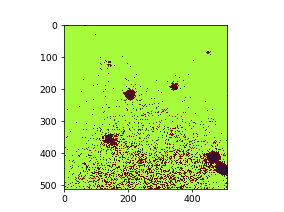

In [16]:
plt.figure()
plt.imshow(best_map, cmap='turbo', interpolation='nearest')

In [17]:
flat_bm = flatten_nav(best_map)

In [18]:
len(np.where(flat_bm ==2)[0])

20105

In [19]:
resample_ds = []
nl_resample_ds = []
for uind in np.unique(flat_bm):
    if uind == 1:
        nsamples = 100
    else:
        nsamples = 8000
    
    print(uind)
    pdf = np.where(flat_bm ==uind, 1, 0)
    npdf = pdf/pdf.sum()
    for i in range(20):
        sdps = hs.signals.Signal2D(flat_dps[np.random.choice(np.arange(flat_dps.shape[0]), nsamples, False, npdf)])
        pn_dps = sdps.copy()
        nl_resample_ds.append(sdps.data)
        #pn_dps.add_poissonian_noise()
        #resample_ds.append(pn_dps)

0
1
2


In [21]:
#resample_ds = np.concatenate([x.data for x in resample_ds],axis = 0)
nl_resample_ds = np.concatenate([x for x in nl_resample_ds],axis = 0)

In [22]:
nl_resample_ds.shape

(322000, 256, 256)

In [23]:
np.random.shuffle(nl_resample_ds)

NotImplementedError: Item assignment with <class 'int'> not supported

In [24]:
nl_resample_ds.shape

(322000, 256, 256)

In [25]:
input_data = data_manip_lowq(nl_resample_ds)
np.random.shuffle(input_data)
#input_targets = data_manip_lowq(nlds)
#val_data = data_manip_lowq(nl_resample_ds[::10])
#np.random.shuffle(val_data)


dask to numpy
dask to numpy done
started data manipulations
resized


<IPython.core.display.Javascript object>


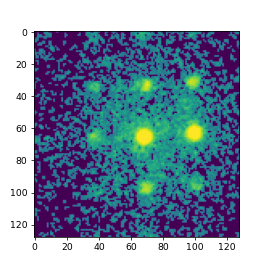

In [26]:
rand_patt = np.random.randint(0, len(input_data))
plt.figure(figsize = (4,4))
plt.imshow(input_data[rand_patt])
#plt.figure(figsize = (4,4))
#plt.imshow(input_targets[rand_patt])

##### Otherwise just skip

In [27]:
print(input_data.shape)

(322000, 128, 128)


In [29]:
batch_size = 8192

train_gen = Array_Generator(input_data, batch_size)#, target = input_targets)
#valid_gen = Array_Generator(val_data, batch_size)

batch_shape = train_gen[0][0].shape
input_shape = (batch_shape[1],batch_shape[2],batch_shape[3])
out_dims = int(train_gen[0][1].shape[1])

### Check the training data

<IPython.core.display.Javascript object>


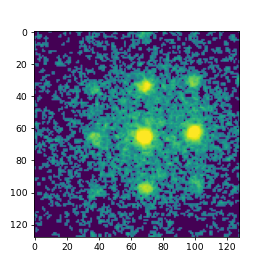

In [30]:
rand_patt = np.random.randint(0, len(input_data))
plt.figure(figsize = (4,4))
plt.imshow(input_data[rand_patt])

### Set the checkpointing

In [31]:
chkpoint_filepath = str(mp)+'/chk-{epoch:02d}-{loss:.5e}.hdf5'
chkpoint_model = tf.keras.callbacks.ModelCheckpoint(
    filepath = chkpoint_filepath,
    monitor="loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    save_freq="epoch",
    options=None)

### Redefine the model parameters if you want

In [32]:
rebin_factor = 1

In [33]:
sample_name = 'full'
hparams= {'KN1':32,'KN2':64,'KN3':128, 'KN4':128, 'KN5':256,'D1':128,'D2':512,'LAT':2,'LR':0.0001, 'B':1}

vae_model = create_vae_model(hparams)
info[sample_name] = {'rebin': rebin_factor, 'hparams':hparams}

2022-03-25 17:16:37.009751: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-25 17:16:37.083873: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2400000000 Hz
2022-03-25 17:16:37.087174: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5558b9c04690 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-03-25 17:16:37.087198: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-03-25 17:16:37.212272: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5558bbb0f060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-03-25 17:16:37.

### Will be helpful to start with a trained model so set one here (otherwise will just take longer)

In [210]:
old_model ='/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-34-8.73786e+03.hdf5'

In [211]:
vae_model.load_weights(old_model)

### Train the Model

In [35]:
history = vae_model.fit(train_gen, epochs=10000, callbacks= [chkpoint_model])

[autoreload of google.protobuf.any_pb2 failed: Traceback (most recent call last):
  File "/home/dto55534/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/dto55534/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/google/protobuf/any_

Epoch 1/10000
 2/40 [>.............................] - ETA: 1:05 - loss: 8693.5688WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.8582s vs `on_train_batch_end` time: 1.2908s). Check your callbacks.


40/40 [==============================] - ETA: 0s - loss: 8693.1181
Epoch 00001: loss did not improve from 8688.63867
40/40 [==============================] - 84s 2s/step - loss: 8693.1411
Epoch 2/10000
40/40 [==============================] - ETA: 0s - loss: 8693.0844
Epoch 00002: loss did not improve from 8688.63867
40/40 [==============================] - 84s 2s/step - loss: 8693.0867
Epoch 3/10000
40/40 [==============================] - ETA: 0s - loss: 8693.3556
Epoch 00003: loss did not improve from 8688.63867
40/40 [==============================] - 84s 2s/step - loss: 8693.3592
Epoch 4/10000
40/40 [==============================] - ETA: 0s - loss: 8693.2146
Epoch 00004: loss did not improve from 8688.63867
40/40 [==============================] - 84s 2s/step - loss: 8693.3150
Epoch 5/10000
40/40 [==============================] - ETA: 0s - loss: 8693.0912
Epoch 00005: loss did not improve from 8688.63867
40/40 [==============================] - 84s 2s/step - loss: 8693.0743
Epoc

Epoch 41/10000
40/40 [==============================] - ETA: 0s - loss: 8693.0888
Epoch 00041: loss did not improve from 8687.92383
40/40 [==============================] - 84s 2s/step - loss: 8693.0448
Epoch 42/10000
40/40 [==============================] - ETA: 0s - loss: 8692.9655
Epoch 00042: loss did not improve from 8687.92383
40/40 [==============================] - 84s 2s/step - loss: 8692.9456
Epoch 43/10000
40/40 [==============================] - ETA: 0s - loss: 8693.2201
Epoch 00043: loss did not improve from 8687.92383
40/40 [==============================] - 84s 2s/step - loss: 8693.1893
Epoch 44/10000
40/40 [==============================] - ETA: 0s - loss: 8692.9535
Epoch 00044: loss did not improve from 8687.92383
40/40 [==============================] - 85s 2s/step - loss: 8692.8946
Epoch 45/10000
40/40 [==============================] - ETA: 0s - loss: 8692.9241
Epoch 00045: loss did not improve from 8687.92383
40/40 [==============================] - 84s 2s/step - l

40/40 [==============================] - ETA: 0s - loss: 8692.8347
Epoch 00081: loss did not improve from 8687.92383
40/40 [==============================] - 84s 2s/step - loss: 8692.8014
Epoch 82/10000
40/40 [==============================] - ETA: 0s - loss: 8692.8279
Epoch 00082: loss did not improve from 8687.92383
40/40 [==============================] - 84s 2s/step - loss: 8692.7667
Epoch 83/10000
40/40 [==============================] - ETA: 0s - loss: 8692.9386
Epoch 00083: loss did not improve from 8687.92383
40/40 [==============================] - 84s 2s/step - loss: 8692.9020
Epoch 84/10000
40/40 [==============================] - ETA: 0s - loss: 8692.7420
Epoch 00084: loss did not improve from 8687.92383
40/40 [==============================] - 84s 2s/step - loss: 8692.8013
Epoch 85/10000
40/40 [==============================] - ETA: 0s - loss: 8692.8274
Epoch 00085: loss did not improve from 8687.92383
40/40 [==============================] - 84s 2s/step - loss: 8692.8642


40/40 [==============================] - ETA: 0s - loss: 8692.9690
Epoch 00121: loss did not improve from 8687.92383
40/40 [==============================] - 84s 2s/step - loss: 8692.9738
Epoch 122/10000
40/40 [==============================] - ETA: 0s - loss: 8692.4694
Epoch 00122: loss did not improve from 8687.92383
40/40 [==============================] - 84s 2s/step - loss: 8692.4013
Epoch 123/10000
40/40 [==============================] - ETA: 0s - loss: 8692.6511
Epoch 00123: loss did not improve from 8687.92383
40/40 [==============================] - 84s 2s/step - loss: 8692.7308
Epoch 124/10000
40/40 [==============================] - ETA: 0s - loss: 8692.6162
Epoch 00124: loss did not improve from 8687.92383
40/40 [==============================] - 84s 2s/step - loss: 8692.6339
Epoch 125/10000
40/40 [==============================] - ETA: 0s - loss: 8692.7803
Epoch 00125: loss did not improve from 8687.92383
40/40 [==============================] - 85s 2s/step - loss: 8692.8

Epoch 161/10000
40/40 [==============================] - ETA: 0s - loss: 8692.5417
Epoch 00161: loss did not improve from 8687.21875
40/40 [==============================] - 84s 2s/step - loss: 8692.5625
Epoch 162/10000
40/40 [==============================] - ETA: 0s - loss: 8692.6286
Epoch 00162: loss did not improve from 8687.21875
40/40 [==============================] - 84s 2s/step - loss: 8692.6473
Epoch 163/10000
40/40 [==============================] - ETA: 0s - loss: 8692.5315
Epoch 00163: loss did not improve from 8687.21875
40/40 [==============================] - 84s 2s/step - loss: 8692.4763
Epoch 164/10000
40/40 [==============================] - ETA: 0s - loss: 8692.4073
Epoch 00164: loss improved from 8687.21875 to 8687.09570, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-164-8.68710e+03.hdf5
40/40 [==============================] - 84s 2s/step - loss: 8692.2778
Epoch 165/10000
40/40 [===================

Epoch 201/10000
40/40 [==============================] - ETA: 0s - loss: 8692.2939
Epoch 00201: loss did not improve from 8687.09570
40/40 [==============================] - 84s 2s/step - loss: 8692.2973
Epoch 202/10000
40/40 [==============================] - ETA: 0s - loss: 8692.5221
Epoch 00202: loss did not improve from 8687.09570
40/40 [==============================] - 84s 2s/step - loss: 8692.5905
Epoch 203/10000
40/40 [==============================] - ETA: 0s - loss: 8692.3907
Epoch 00203: loss did not improve from 8687.09570
40/40 [==============================] - 84s 2s/step - loss: 8692.4319
Epoch 204/10000
40/40 [==============================] - ETA: 0s - loss: 8692.3257
Epoch 00204: loss did not improve from 8687.09570
40/40 [==============================] - 84s 2s/step - loss: 8692.2198
Epoch 205/10000
40/40 [==============================] - ETA: 0s - loss: 8692.2893
Epoch 00205: loss did not improve from 8687.09570
40/40 [==============================] - 85s 2s/ste

40/40 [==============================] - ETA: 0s - loss: 8692.0930
Epoch 00241: loss did not improve from 8687.09570
40/40 [==============================] - 84s 2s/step - loss: 8692.0933
Epoch 242/10000
40/40 [==============================] - ETA: 0s - loss: 8692.1592
Epoch 00242: loss did not improve from 8687.09570
40/40 [==============================] - 84s 2s/step - loss: 8692.1973
Epoch 243/10000
40/40 [==============================] - ETA: 0s - loss: 8692.2772
Epoch 00243: loss did not improve from 8687.09570
40/40 [==============================] - 84s 2s/step - loss: 8692.1741
Epoch 244/10000
40/40 [==============================] - ETA: 0s - loss: 8692.0395
Epoch 00244: loss did not improve from 8687.09570
40/40 [==============================] - 84s 2s/step - loss: 8692.0190
Epoch 245/10000
40/40 [==============================] - ETA: 0s - loss: 8692.1324
Epoch 00245: loss improved from 8687.09570 to 8686.76367, saving model to /dls/science/groups/imaging/ePSIC_students/

Epoch 280/10000
40/40 [==============================] - ETA: 0s - loss: 8691.9971
Epoch 00280: loss did not improve from 8686.52441
40/40 [==============================] - 84s 2s/step - loss: 8691.9457
Epoch 281/10000
40/40 [==============================] - ETA: 0s - loss: 8692.5149
Epoch 00281: loss did not improve from 8686.52441
40/40 [==============================] - 84s 2s/step - loss: 8692.4065
Epoch 282/10000
40/40 [==============================] - ETA: 0s - loss: 8691.9229
Epoch 00282: loss did not improve from 8686.52441
40/40 [==============================] - 84s 2s/step - loss: 8691.8525
Epoch 283/10000
40/40 [==============================] - ETA: 0s - loss: 8692.0211
Epoch 00283: loss did not improve from 8686.52441
40/40 [==============================] - 84s 2s/step - loss: 8692.0507
Epoch 284/10000
40/40 [==============================] - ETA: 0s - loss: 8691.8662
Epoch 00284: loss did not improve from 8686.52441
40/40 [==============================] - 84s 2s/ste

Epoch 320/10000
40/40 [==============================] - ETA: 0s - loss: 8692.0653
Epoch 00320: loss did not improve from 8686.48535
40/40 [==============================] - 84s 2s/step - loss: 8692.0160
Epoch 321/10000
40/40 [==============================] - ETA: 0s - loss: 8691.9174
Epoch 00321: loss did not improve from 8686.48535
40/40 [==============================] - 84s 2s/step - loss: 8691.8755
Epoch 322/10000
40/40 [==============================] - ETA: 0s - loss: 8691.8426
Epoch 00322: loss did not improve from 8686.48535
40/40 [==============================] - 84s 2s/step - loss: 8691.8530
Epoch 323/10000
40/40 [==============================] - ETA: 0s - loss: 8691.7654
Epoch 00323: loss did not improve from 8686.48535
40/40 [==============================] - 84s 2s/step - loss: 8691.7724
Epoch 324/10000
40/40 [==============================] - ETA: 0s - loss: 8692.1342
Epoch 00324: loss did not improve from 8686.48535
40/40 [==============================] - 84s 2s/ste

40/40 [==============================] - ETA: 0s - loss: 8691.7579
Epoch 00360: loss did not improve from 8686.48535
40/40 [==============================] - 84s 2s/step - loss: 8691.8118
Epoch 361/10000
40/40 [==============================] - ETA: 0s - loss: 8691.6979
Epoch 00361: loss did not improve from 8686.48535
40/40 [==============================] - 84s 2s/step - loss: 8691.7110
Epoch 362/10000
40/40 [==============================] - ETA: 0s - loss: 8691.6775
Epoch 00362: loss did not improve from 8686.48535
40/40 [==============================] - 84s 2s/step - loss: 8691.6343
Epoch 363/10000
40/40 [==============================] - ETA: 0s - loss: 8691.8149
Epoch 00363: loss did not improve from 8686.48535
40/40 [==============================] - 84s 2s/step - loss: 8691.8303
Epoch 364/10000
40/40 [==============================] - ETA: 0s - loss: 8691.6939
Epoch 00364: loss did not improve from 8686.48535
40/40 [==============================] - 84s 2s/step - loss: 8691.6

40/40 [==============================] - ETA: 0s - loss: 8691.4066
Epoch 00400: loss did not improve from 8686.48535
40/40 [==============================] - 84s 2s/step - loss: 8691.3683
Epoch 401/10000
40/40 [==============================] - ETA: 0s - loss: 8692.4317
Epoch 00401: loss did not improve from 8686.48535
40/40 [==============================] - 84s 2s/step - loss: 8692.5415
Epoch 402/10000
40/40 [==============================] - ETA: 0s - loss: 8691.6189
Epoch 00402: loss did not improve from 8686.48535
40/40 [==============================] - 84s 2s/step - loss: 8691.5218
Epoch 403/10000
40/40 [==============================] - ETA: 0s - loss: 8691.3777
Epoch 00403: loss did not improve from 8686.48535
40/40 [==============================] - 84s 2s/step - loss: 8691.3997
Epoch 404/10000
40/40 [==============================] - ETA: 0s - loss: 8691.7084
Epoch 00404: loss did not improve from 8686.48535
40/40 [==============================] - 84s 2s/step - loss: 8691.7

40/40 [==============================] - ETA: 0s - loss: 8691.2273
Epoch 00440: loss did not improve from 8686.48535
40/40 [==============================] - 84s 2s/step - loss: 8691.1760
Epoch 441/10000
40/40 [==============================] - ETA: 0s - loss: 8691.6959
Epoch 00441: loss did not improve from 8686.48535
40/40 [==============================] - 84s 2s/step - loss: 8691.8212
Epoch 442/10000
40/40 [==============================] - ETA: 0s - loss: 8691.2497
Epoch 00442: loss did not improve from 8686.48535
40/40 [==============================] - 84s 2s/step - loss: 8691.2875
Epoch 443/10000
40/40 [==============================] - ETA: 0s - loss: 8691.4662
Epoch 00443: loss did not improve from 8686.48535
40/40 [==============================] - 84s 2s/step - loss: 8691.3962
Epoch 444/10000
40/40 [==============================] - ETA: 0s - loss: 8691.5496
Epoch 00444: loss did not improve from 8686.48535
40/40 [==============================] - 84s 2s/step - loss: 8691.6

Epoch 480/10000
40/40 [==============================] - ETA: 0s - loss: 8691.2793
Epoch 00480: loss did not improve from 8685.42383
40/40 [==============================] - 84s 2s/step - loss: 8691.2993
Epoch 481/10000
40/40 [==============================] - ETA: 0s - loss: 8691.1364
Epoch 00481: loss did not improve from 8685.42383
40/40 [==============================] - 84s 2s/step - loss: 8691.1749
Epoch 482/10000
40/40 [==============================] - ETA: 0s - loss: 8691.2637
Epoch 00482: loss did not improve from 8685.42383
40/40 [==============================] - 84s 2s/step - loss: 8691.2636
Epoch 483/10000
40/40 [==============================] - ETA: 0s - loss: 8691.3377
Epoch 00483: loss did not improve from 8685.42383
40/40 [==============================] - 84s 2s/step - loss: 8691.3952
Epoch 484/10000
40/40 [==============================] - ETA: 0s - loss: 8691.3021
Epoch 00484: loss did not improve from 8685.42383
40/40 [==============================] - 84s 2s/ste

40/40 [==============================] - ETA: 0s - loss: 8691.4788
Epoch 00520: loss did not improve from 8685.42383
40/40 [==============================] - 84s 2s/step - loss: 8691.5313
Epoch 521/10000
40/40 [==============================] - ETA: 0s - loss: 8691.0490
Epoch 00521: loss did not improve from 8685.42383
40/40 [==============================] - 84s 2s/step - loss: 8691.0605
Epoch 522/10000
40/40 [==============================] - ETA: 0s - loss: 8691.1130
Epoch 00522: loss did not improve from 8685.42383
40/40 [==============================] - 84s 2s/step - loss: 8691.0509
Epoch 523/10000
40/40 [==============================] - ETA: 0s - loss: 8690.9139
Epoch 00523: loss did not improve from 8685.42383
40/40 [==============================] - 84s 2s/step - loss: 8690.8589
Epoch 524/10000
40/40 [==============================] - ETA: 0s - loss: 8691.6434
Epoch 00524: loss did not improve from 8685.42383
40/40 [==============================] - 84s 2s/step - loss: 8691.6

Epoch 559/10000
40/40 [==============================] - ETA: 0s - loss: 8690.9142
Epoch 00559: loss did not improve from 8685.04004
40/40 [==============================] - 84s 2s/step - loss: 8690.9287
Epoch 560/10000
40/40 [==============================] - ETA: 0s - loss: 8690.8509
Epoch 00560: loss did not improve from 8685.04004
40/40 [==============================] - 85s 2s/step - loss: 8690.8481
Epoch 561/10000
40/40 [==============================] - ETA: 0s - loss: 8690.9137
Epoch 00561: loss did not improve from 8685.04004
40/40 [==============================] - 84s 2s/step - loss: 8690.8115
Epoch 562/10000
40/40 [==============================] - ETA: 0s - loss: 8691.1415
Epoch 00562: loss did not improve from 8685.04004
40/40 [==============================] - 84s 2s/step - loss: 8691.2534
Epoch 563/10000
40/40 [==============================] - ETA: 0s - loss: 8690.9358
Epoch 00563: loss did not improve from 8685.04004
40/40 [==============================] - 84s 2s/ste

40/40 [==============================] - ETA: 0s - loss: 8690.7950
Epoch 00599: loss did not improve from 8685.04004
40/40 [==============================] - 84s 2s/step - loss: 8690.8363
Epoch 600/10000
40/40 [==============================] - ETA: 0s - loss: 8690.7676
Epoch 00600: loss did not improve from 8685.04004
40/40 [==============================] - 84s 2s/step - loss: 8690.7331
Epoch 601/10000
40/40 [==============================] - ETA: 0s - loss: 8690.9006
Epoch 00601: loss did not improve from 8685.04004
40/40 [==============================] - 84s 2s/step - loss: 8690.8761
Epoch 602/10000
40/40 [==============================] - ETA: 0s - loss: 8690.6614
Epoch 00602: loss did not improve from 8685.04004
40/40 [==============================] - 84s 2s/step - loss: 8690.6068
Epoch 603/10000
40/40 [==============================] - ETA: 0s - loss: 8690.8109
Epoch 00603: loss did not improve from 8685.04004
40/40 [==============================] - 84s 2s/step - loss: 8690.9

40/40 [==============================] - ETA: 0s - loss: 8690.5383
Epoch 00639: loss did not improve from 8685.04004
40/40 [==============================] - 84s 2s/step - loss: 8690.4812
Epoch 640/10000
40/40 [==============================] - ETA: 0s - loss: 8690.8009
Epoch 00640: loss improved from 8685.04004 to 8684.55859, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-640-8.68456e+03.hdf5
40/40 [==============================] - 84s 2s/step - loss: 8690.6486
Epoch 641/10000
40/40 [==============================] - ETA: 0s - loss: 8690.4696
Epoch 00641: loss did not improve from 8684.55859
40/40 [==============================] - 84s 2s/step - loss: 8690.4207
Epoch 642/10000
40/40 [==============================] - ETA: 0s - loss: 8690.5922
Epoch 00642: loss did not improve from 8684.55859
40/40 [==============================] - 84s 2s/step - loss: 8690.6995
Epoch 643/10000
40/40 [==============================] - E

Epoch 679/10000
40/40 [==============================] - ETA: 0s - loss: 8690.5359
Epoch 00679: loss did not improve from 8684.55859
40/40 [==============================] - 84s 2s/step - loss: 8690.4891
Epoch 680/10000
40/40 [==============================] - ETA: 0s - loss: 8690.8174
Epoch 00680: loss did not improve from 8684.55859
40/40 [==============================] - 84s 2s/step - loss: 8690.7717
Epoch 681/10000
40/40 [==============================] - ETA: 0s - loss: 8690.5042
Epoch 00681: loss did not improve from 8684.55859
40/40 [==============================] - 84s 2s/step - loss: 8690.4124
Epoch 682/10000
40/40 [==============================] - ETA: 0s - loss: 8690.5617
Epoch 00682: loss did not improve from 8684.55859
40/40 [==============================] - 84s 2s/step - loss: 8690.5136
Epoch 683/10000
40/40 [==============================] - ETA: 0s - loss: 8690.4536
Epoch 00683: loss did not improve from 8684.55859
40/40 [==============================] - 84s 2s/ste

40/40 [==============================] - ETA: 0s - loss: 8690.2973
Epoch 00719: loss did not improve from 8684.55859
40/40 [==============================] - 84s 2s/step - loss: 8690.2888
Epoch 720/10000
40/40 [==============================] - ETA: 0s - loss: 8690.4422
Epoch 00720: loss did not improve from 8684.55859
40/40 [==============================] - 84s 2s/step - loss: 8690.3974
Epoch 721/10000
40/40 [==============================] - ETA: 0s - loss: 8690.1485
Epoch 00721: loss did not improve from 8684.55859
40/40 [==============================] - 84s 2s/step - loss: 8690.2304
Epoch 722/10000
40/40 [==============================] - ETA: 0s - loss: 8690.8817
Epoch 00722: loss did not improve from 8684.55859
40/40 [==============================] - 84s 2s/step - loss: 8690.8851
Epoch 723/10000
40/40 [==============================] - ETA: 0s - loss: 8690.2509
Epoch 00723: loss did not improve from 8684.55859
40/40 [==============================] - 84s 2s/step - loss: 8690.2

40/40 [==============================] - ETA: 0s - loss: 8690.0193
Epoch 00759: loss did not improve from 8684.55859
40/40 [==============================] - 84s 2s/step - loss: 8690.0843
Epoch 760/10000
40/40 [==============================] - ETA: 0s - loss: 8690.2570
Epoch 00760: loss did not improve from 8684.55859
40/40 [==============================] - 84s 2s/step - loss: 8690.2888
Epoch 761/10000
40/40 [==============================] - ETA: 0s - loss: 8690.0914
Epoch 00761: loss did not improve from 8684.55859
40/40 [==============================] - 85s 2s/step - loss: 8690.0272
Epoch 762/10000
40/40 [==============================] - ETA: 0s - loss: 8690.3848
Epoch 00762: loss did not improve from 8684.55859
40/40 [==============================] - 84s 2s/step - loss: 8690.3284
Epoch 763/10000
40/40 [==============================] - ETA: 0s - loss: 8690.4291
Epoch 00763: loss did not improve from 8684.55859
40/40 [==============================] - 84s 2s/step - loss: 8690.3

Epoch 799/10000
40/40 [==============================] - ETA: 0s - loss: 8690.0097
Epoch 00799: loss did not improve from 8683.95117
40/40 [==============================] - 84s 2s/step - loss: 8690.0482
Epoch 800/10000
40/40 [==============================] - ETA: 0s - loss: 8690.1555
Epoch 00800: loss did not improve from 8683.95117
40/40 [==============================] - 84s 2s/step - loss: 8690.1790
Epoch 801/10000
40/40 [==============================] - ETA: 0s - loss: 8690.1318
Epoch 00801: loss did not improve from 8683.95117
40/40 [==============================] - 84s 2s/step - loss: 8690.0700
Epoch 802/10000
40/40 [==============================] - ETA: 0s - loss: 8689.9868
Epoch 00802: loss did not improve from 8683.95117
40/40 [==============================] - 84s 2s/step - loss: 8689.9183
Epoch 803/10000
40/40 [==============================] - ETA: 0s - loss: 8690.1347
Epoch 00803: loss did not improve from 8683.95117
40/40 [==============================] - 84s 2s/ste

40/40 [==============================] - ETA: 0s - loss: 8689.7368
Epoch 00839: loss did not improve from 8683.95117
40/40 [==============================] - 84s 2s/step - loss: 8689.6753
Epoch 840/10000
40/40 [==============================] - ETA: 0s - loss: 8690.0441
Epoch 00840: loss did not improve from 8683.95117
40/40 [==============================] - 84s 2s/step - loss: 8690.0078
Epoch 841/10000
40/40 [==============================] - ETA: 0s - loss: 8689.9340
Epoch 00841: loss did not improve from 8683.95117
40/40 [==============================] - 84s 2s/step - loss: 8689.9040
Epoch 842/10000
40/40 [==============================] - ETA: 0s - loss: 8690.3152
Epoch 00842: loss did not improve from 8683.95117
40/40 [==============================] - 84s 2s/step - loss: 8690.2570
Epoch 843/10000
40/40 [==============================] - ETA: 0s - loss: 8689.6431
Epoch 00843: loss did not improve from 8683.95117
40/40 [==============================] - 84s 2s/step - loss: 8689.6

40/40 [==============================] - ETA: 0s - loss: 8690.0140
Epoch 00879: loss did not improve from 8683.95117
40/40 [==============================] - 84s 2s/step - loss: 8689.9835
Epoch 880/10000
40/40 [==============================] - ETA: 0s - loss: 8689.8901
Epoch 00880: loss did not improve from 8683.95117
40/40 [==============================] - 84s 2s/step - loss: 8689.9238
Epoch 881/10000
40/40 [==============================] - ETA: 0s - loss: 8689.6966
Epoch 00881: loss did not improve from 8683.95117
40/40 [==============================] - 84s 2s/step - loss: 8689.6516
Epoch 882/10000
40/40 [==============================] - ETA: 0s - loss: 8689.8648
Epoch 00882: loss did not improve from 8683.95117
40/40 [==============================] - 84s 2s/step - loss: 8689.8301
Epoch 883/10000
40/40 [==============================] - ETA: 0s - loss: 8689.6170
Epoch 00883: loss did not improve from 8683.95117
40/40 [==============================] - 84s 2s/step - loss: 8689.5

Epoch 919/10000
40/40 [==============================] - ETA: 0s - loss: 8689.5568
Epoch 00919: loss did not improve from 8683.73926
40/40 [==============================] - 84s 2s/step - loss: 8689.5138
Epoch 920/10000
40/40 [==============================] - ETA: 0s - loss: 8689.8317
Epoch 00920: loss did not improve from 8683.73926
40/40 [==============================] - 84s 2s/step - loss: 8689.8147
Epoch 921/10000
40/40 [==============================] - ETA: 0s - loss: 8689.7682
Epoch 00921: loss did not improve from 8683.73926
40/40 [==============================] - 84s 2s/step - loss: 8689.7102
Epoch 922/10000
40/40 [==============================] - ETA: 0s - loss: 8689.8665
Epoch 00922: loss did not improve from 8683.73926
40/40 [==============================] - 84s 2s/step - loss: 8689.8687
Epoch 923/10000
40/40 [==============================] - ETA: 0s - loss: 8689.6066
Epoch 00923: loss did not improve from 8683.73926
40/40 [==============================] - 84s 2s/ste

KeyboardInterrupt: 

In [97]:
vae_model.save_weights('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/ntest.hdf5')